In [128]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [129]:
df = pd.read_csv("dataset.csv")

In [130]:
df.head()

,Number,Query,Department
0,1,I have not yet r...,ISSS
1,2,When will the tr...,Students centre
2,3,Can I participat...,Students centre
3,4,When will be the...,ACES
4,5,I am unable to l...,IT


In [131]:
df = df.rename(columns={'Query': 'query', 'Department': 'department'})
df.head()

,Number,query,department
0,1,I have not yet r...,ISSS
1,2,When will the tr...,Students centre
2,3,Can I participat...,Students centre
3,4,When will be the...,ACES
4,5,I am unable to l...,IT


In [132]:
df['query'].isnull().sum()

0

In [133]:
df[df['query']==''] = np.nan

In [134]:
# cleaning text (lower case, removing brackets, removing punctuations, removing words with numbers)
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [135]:
df.query = df['query'].apply(lambda x: clean_text(x))
df.query.head()

0    i have not yet r...
1    when will the tr...
2    can i participat...
3    when will be the...
4    i am unable to l...
Name: query, dtype: object

In [136]:
# Lemmatizing
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [137]:
df['lemma'] =  df['query'].apply(lambda x: lemmatizer(x))
df.head()

,Number,query,department,lemma
0,1,I have not yet r...,ISSS,I recieve i20 . ...
1,2,When will the tr...,Students centre,when trial hold ...
2,3,Can I participat...,Students centre,can I participat...
3,4,When will be the...,ACES,when career fair...
4,5,I am unable to l...,IT,I unable login a...


In [138]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['query','lemma','department']]
df_clean.head()

,query,lemma,department
0,I have not yet r...,I recieve i20 . ...,ISSS
1,When will the tr...,when trial hold ...,Students centre
2,Can I participat...,can I participat...,Students centre
3,When will be the...,when career fair...,ACES
4,I am unable to l...,I unable login a...,IT


In [139]:
# Function to extract the POS tags NN
def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

In [140]:
df_clean['query_POS_removed'] =  df_clean.lemma.apply(lambda x: extract_pos_tags(x))
df_clean.head()

,query,lemma,department,query_POS_removed
0,I have not yet r...,I recieve i20 . ...,ISSS,date interview a...
1,When will the tr...,when trial hold ...,Students centre,trial soccer team
2,Can I participat...,can I participat...,Students centre,game
3,When will be the...,when career fair...,ACES,student hold
4,I am unable to l...,I unable login a...,IT,login account


(array([4., 3., 1., 4., 0., 3., 1., 8., 4., 1., 2., 2., 1., 2., 3., 2., 1.,
        3., 4., 1., 1., 2., 2., 0., 2., 3., 2., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 2., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.]),
 array([  0.  ,   2.08,   4.16,   6.24,   8.32,  10.4 ,  12.48,  14.56,
         16.64,  18.72,  20.8 ,  22.88,  24.96,  27.04,  29.12,  31.2 ,
         33.28,  35.36,  37.44,  39.52,  41.6 ,  43.68,  45.76,  47.84,
         49.92,  52.  ,  54.08,  56.16,  58.24,  60.32,  62.4 ,  64.48,
         66.56,  68.64,  70.72,  72.8 ,  74.88,  76.96,  79.04,  81.12,
         83.2 ,  85.28,  87.36,  89.44,  91.52,  93.6 ,  95.68,  97.76,
         99.84, 101.92, 104.  ]),
 <BarContainer object of 50 artists>)

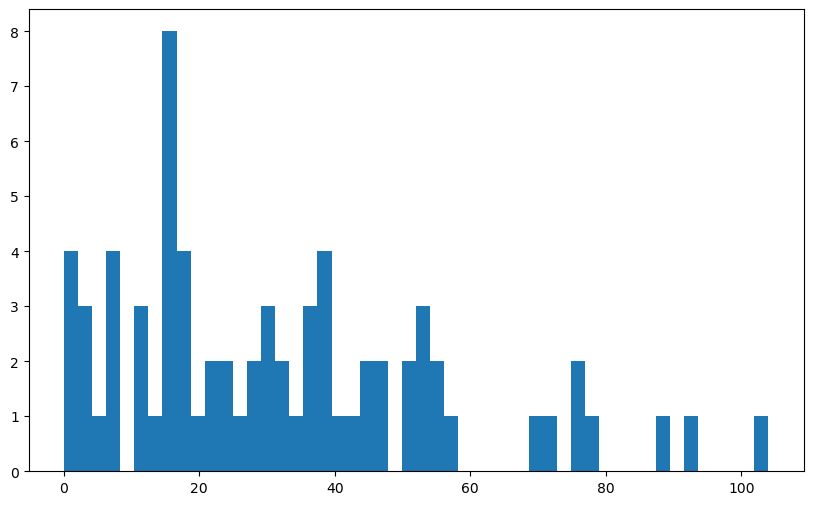

In [141]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.query_POS_removed]
plt.hist(doc_lens, bins = 50)

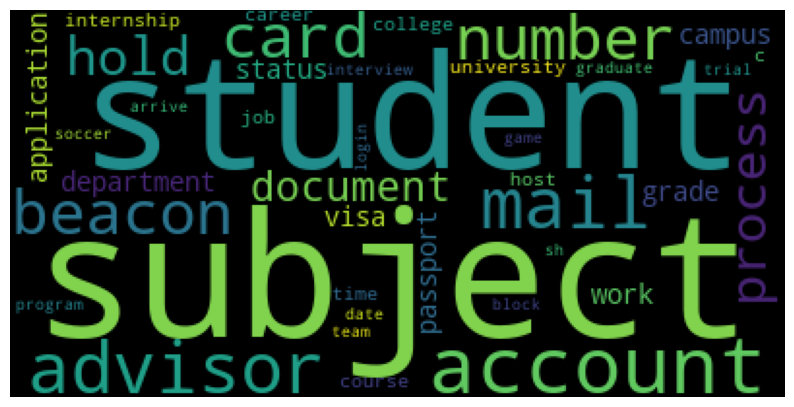

In [142]:
wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.query_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [143]:
df_clean['Query_clean'] = df_clean['query_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['query_POS_removed'],axis = 1)

In [144]:
# Top n-grams
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [145]:
top_30_unigrams = get_top_n_bigram(df_clean.Query_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Query_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Query_clean,ngram=3, top=30)

In [146]:
# Unigrams
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('process', 13),
 ('student', 8),
 ('subject', 8),
 ('university', 8),
 ('account', 7),
 ('internship', 6),
 ('team', 5),
 ('department', 5),
 ('mail', 5),
 ('work', 5)]

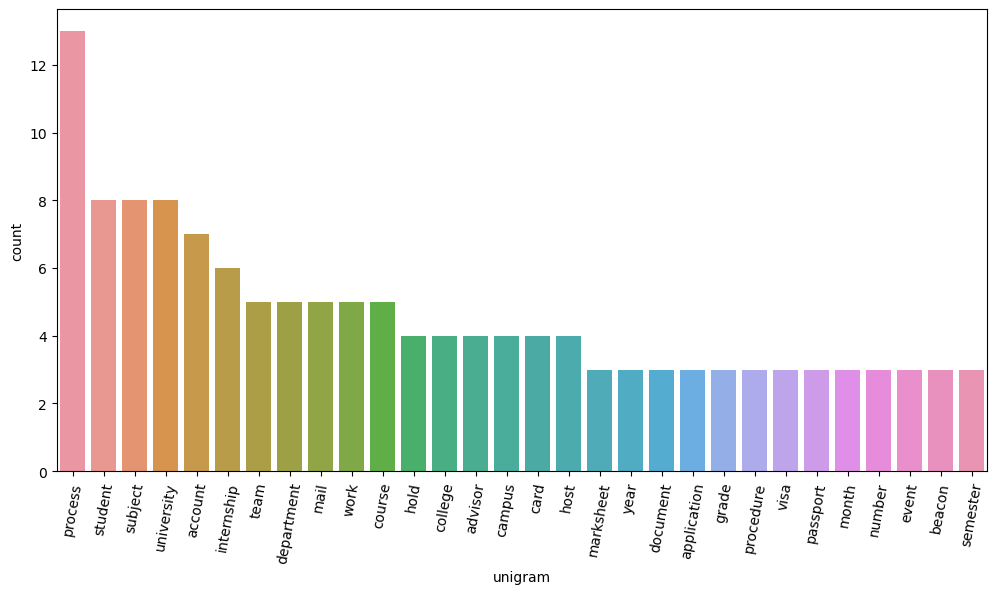

In [147]:
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [148]:
# Bigrams
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('beacon card', 3),
 ('soccer team', 2),
 ('department enrollment', 2),
 ('enrollment process', 2),
 ('step process', 2),
 ('college premise', 2),
 ('course catalogue', 2),
 ('university website', 2),
 ('cover letter', 2),
 ('date interview', 1)]

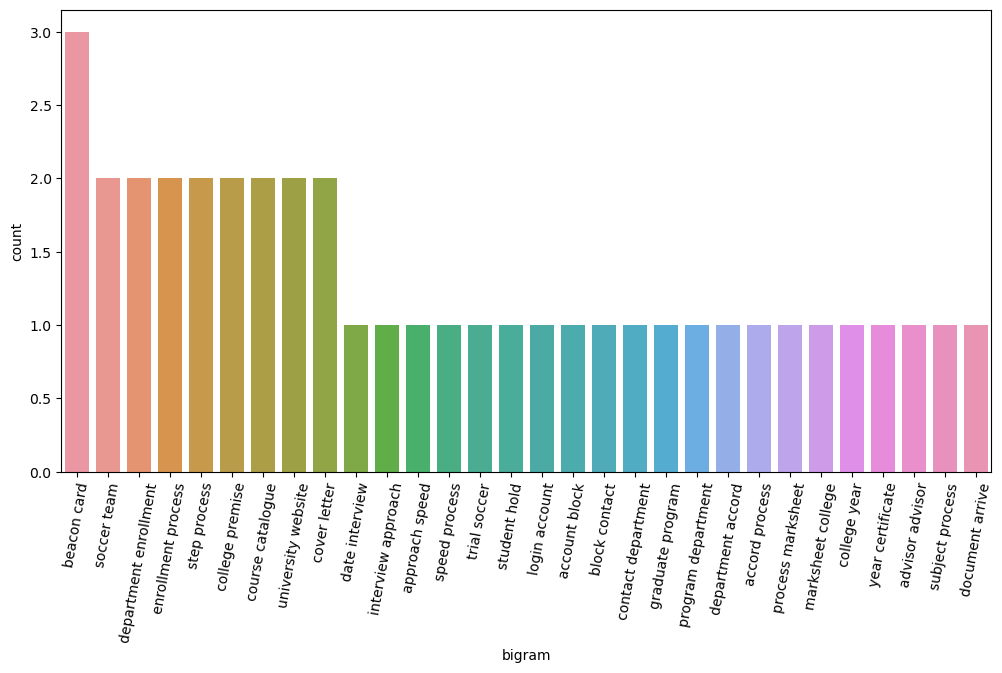

In [149]:
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [150]:
# Top trigrams
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('department enrollment process', 2),
 ('date interview approach', 1),
 ('interview approach speed', 1),
 ('approach speed process', 1),
 ('trial soccer team', 1),
 ('account block contact', 1),
 ('block contact department', 1),
 ('graduate program department', 1),
 ('program department accord', 1),
 ('department accord process', 1)]

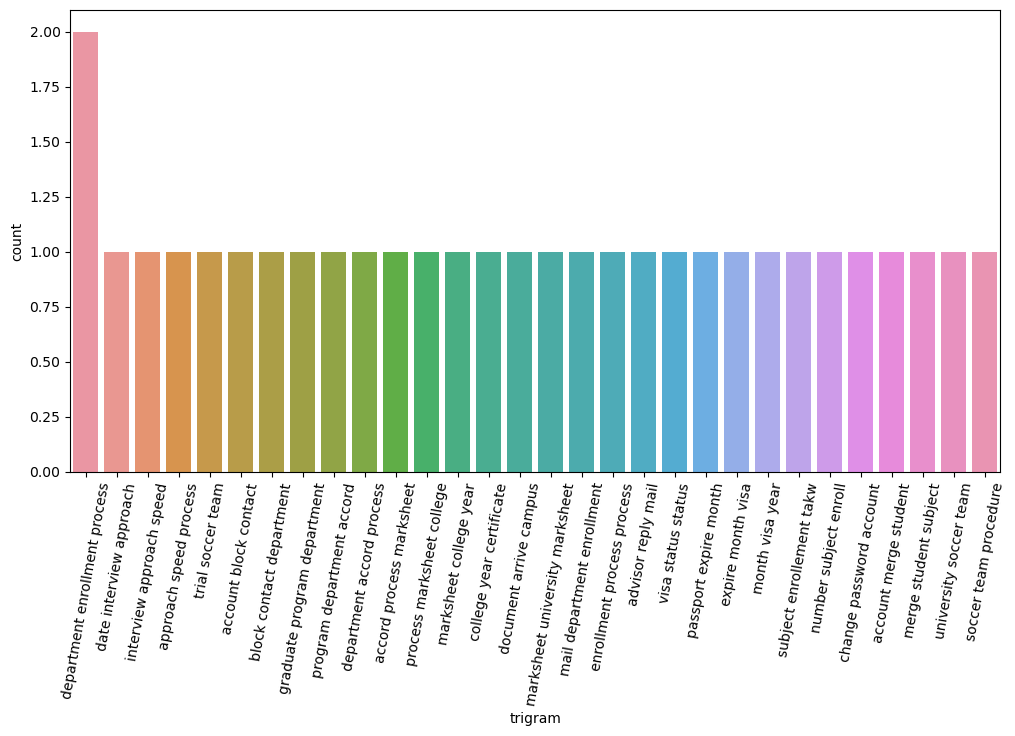

In [151]:
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

In [152]:
df_clean.head()

,query,lemma,department,Query_clean
0,I have not yet r...,I recieve i20 . ...,ISSS,date interview a...
1,When will the tr...,when trial hold ...,Students centre,trial soccer team
2,Can I participat...,can I participat...,Students centre,game
3,When will be the...,when career fair...,ACES,student hold
4,I am unable to l...,I unable login a...,IT,login account


In [153]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [154]:
dtm = tfidf.fit_transform(df_clean.Query_clean) 

In [155]:
tfidf.get_feature_names_out()[:10]
len(tfidf.get_feature_names_out())

59

In [156]:
# Taking 5 clusters
num_topics =  5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [157]:
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [158]:
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Query_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.0,0.34,0.00,0.00,0.00,1
Doc1,0.0,0.00,0.00,0.04,0.07,4
Doc2,0.0,0.03,0.00,0.00,0.00,1
Doc3,0.0,0.00,0.09,0.51,0.00,3
Doc4,0.0,0.00,0.77,0.00,0.00,2


In [159]:
# Assigning best topic to each Query
df_clean['Topic'] = significant_topic

In [160]:
pd.set_option('display.max_colwidth', 20)

In [161]:
# Showing the Topic to which Query has been allocated in sorted order
temp =df_clean[['query','Query_clean','department','Topic']].groupby('Topic').head(10)
temp.sort_values('Topic')

,query,Query_clean,department,Topic
10,Where can I get ...,subject,Department Admin...,0
19,Can you explain ...,way subject,Department Admin...,0
25,What is permissi...,permission number,Department Admin...,0
26,How to join intr...,,Students centre,0
27,What all Student...,,Students centre,0
13,How should I mai...,,ISSS,0
30,I can see some o...,detail,IT,0
24,How can I get pe...,number subject e...,Department Admin...,0
9,I am unable to e...,subject process,Department Admin...,0
23,The subject I ch...,subject enrollem...,Department Admin...,0


In [162]:
# Mapping topic number to the department
topic_mapping = {
    1: 'ISSS',
    2: 'Student Centre',
    4: 'Department Administrator',
    3: 'IT Department',
    0: 'ACES'
}

df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [163]:
df_clean.head()

,query,lemma,department,Query_clean,Topic
0,I have not yet r...,I recieve i20 . ...,ISSS,date interview a...,ISSS
1,When will the tr...,when trial hold ...,Students centre,trial soccer team,Department Admin...
2,Can I participat...,can I participat...,Students centre,game,ISSS
3,When will be the...,when career fair...,ACES,student hold,IT Department
4,I am unable to l...,I unable login a...,IT,login account,Student Centre


<Axes: xlabel='Topic', ylabel='count'>

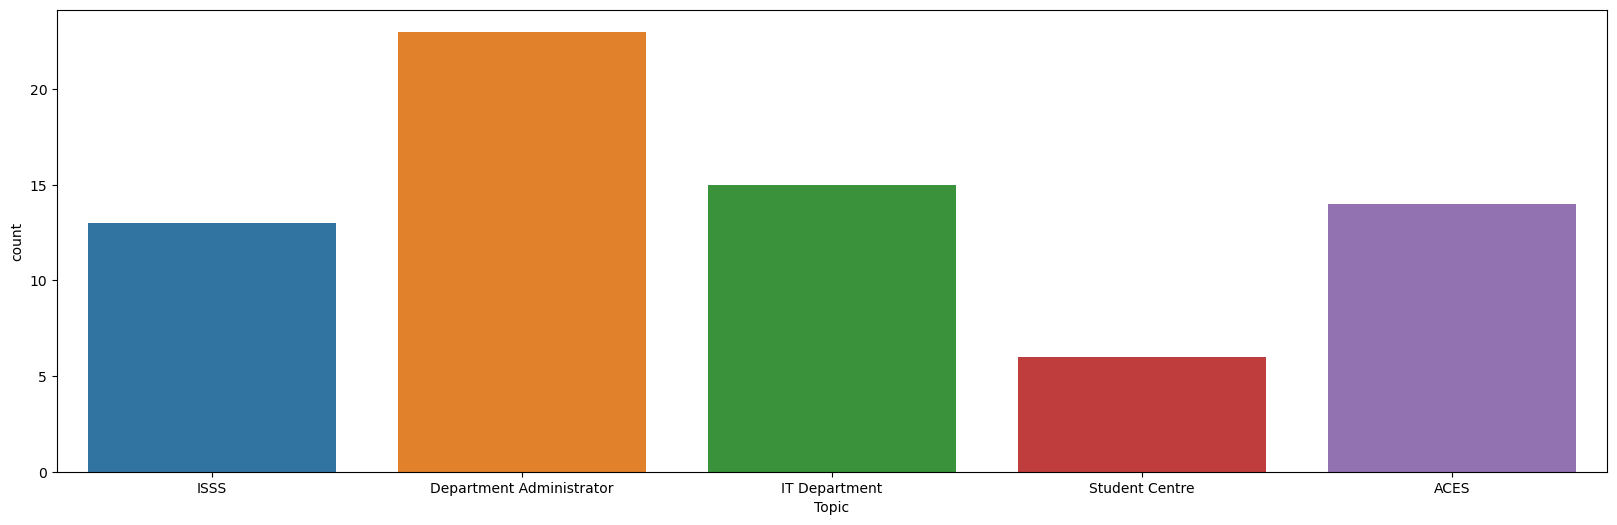

In [164]:
# Checking whether any class is unbalanced or not
plt.figure(figsize=(20,6))
sns.countplot(x='Topic',data=df_clean)

# SUPERVISED LEARNING

In [165]:
training_data = df_clean[['query','Topic']]
training_data.head()

,query,Topic
0,I have not yet r...,ISSS
1,When will the tr...,Department Admin...
2,Can I participat...,ISSS
3,When will be the...,IT Department
4,I am unable to l...,Student Centre


In [166]:
reverse_topic_mapping = {
    'ISSS' : 1,
    'Student Centre' : 2,
    'Department Administrator' : 4,
    'IT Department' : 3,
    'ACES' : 0
}

training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head(20)

,query,Topic
0,I have not yet r...,1
1,When will the tr...,4
2,Can I participat...,1
3,When will be the...,3
4,I am unable to l...,2
5,My wiser account...,2
6,I am currently e...,1
7,How should I con...,3
8,Can you tell me ...,3
9,I am unable to e...,0


In [167]:
X = training_data['query']
y = training_data['Topic']

In [168]:
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [169]:
# Converting raw data into matrices
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [170]:
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=0, stratify=y)

In [171]:
def curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring=None):

    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# MAKING MODELS

 THE FOLLOWING 4 ALGORITHIMS WILL BE USED FOR COMPARISON OF RESULTS

1. MULTINOMIAL NAIVE BAYES
2. LOGISTIC REGRESSION
3. DECISION TREES
4. RANDOM FOREST

In [172]:
def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.86
Train Accuracy : 1.0
Test Accuracy : 0.72
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        17

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.50      0.67      0.57         3
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         4
           4       0.83      0.83      0.83         6

    accuracy              

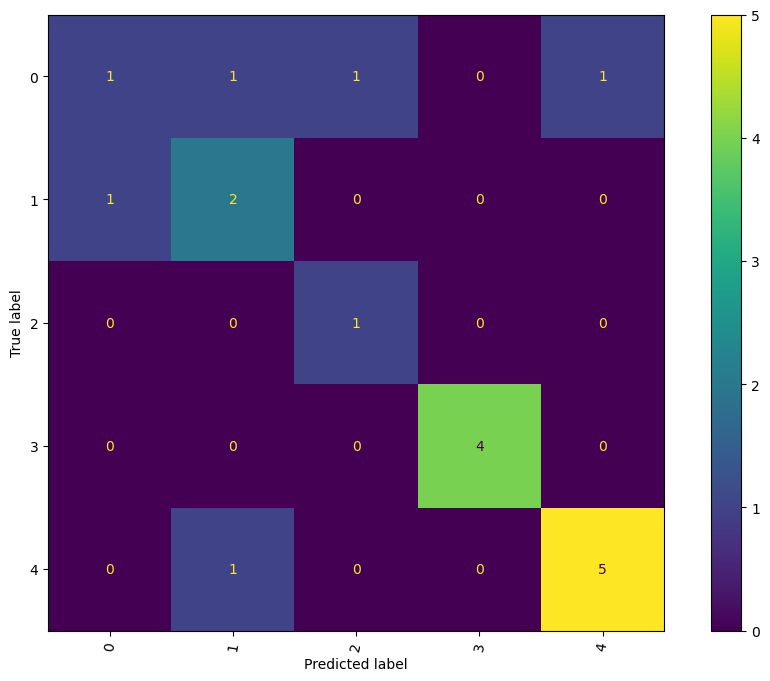

In [173]:
# Making Multinomial Naive Bayes Model
mnb = MultinomialNB(alpha = 000.1)
h = mnb.fit(X_train, y_train)
metric1=[]
display_classification_report(mnb,metric1)

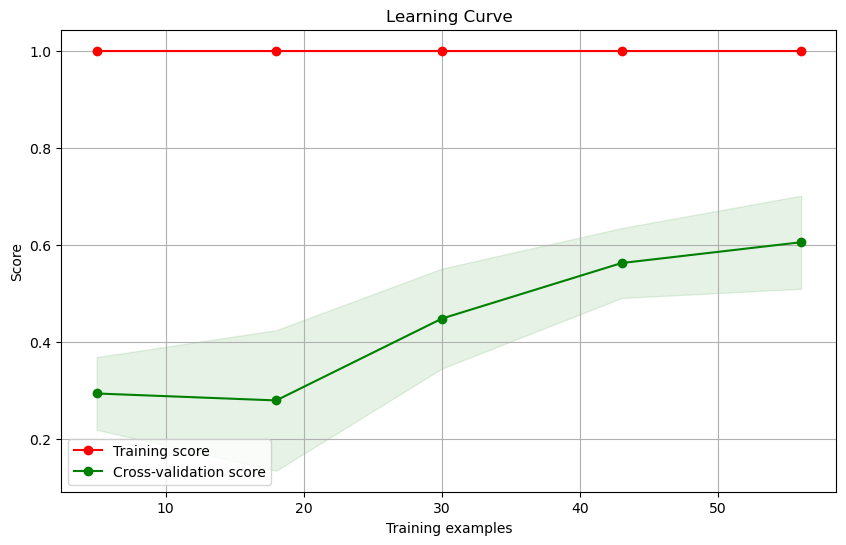

In [174]:
curve(mnb, X_tfidf, y, cv=5, scoring='accuracy')

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.85
Train Accuracy : 1.0
Test Accuracy : 0.56
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        17

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.50      0.67      0.57         3
           2       1.00      1.00      1.00         1
           3       0.67      1.00      0.80         4
           4       0.50      0.33      0.40         6

    accuracy              

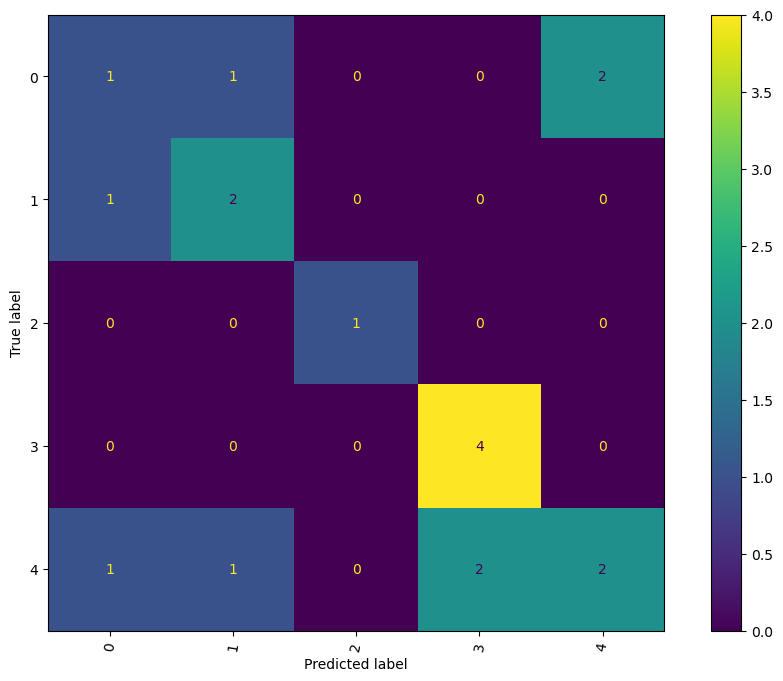

In [175]:
# Making Lostic Regression Model
log_reg = LogisticRegression(random_state=40,solver='liblinear',penalty ='l1', C = 5000)
log_reg.fit(X_train,y_train)
metric2=[]
display_classification_report(log_reg,metric2)

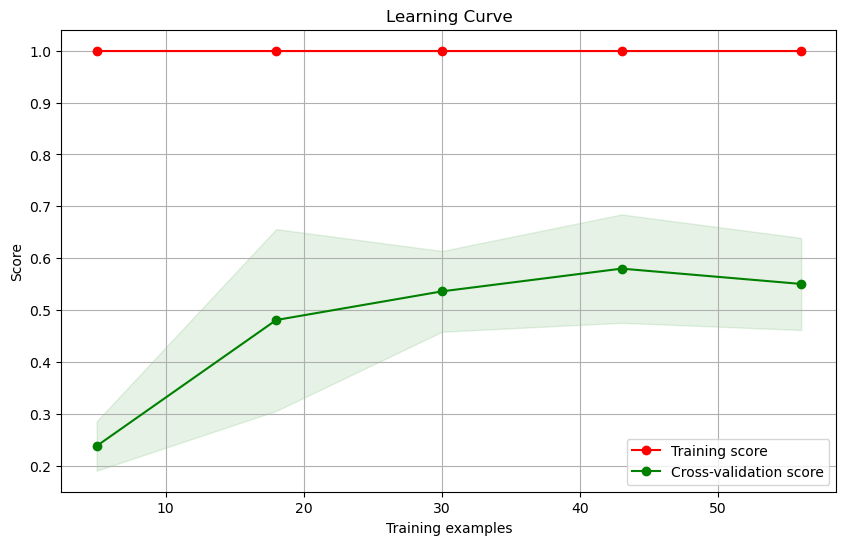

In [176]:
curve(log_reg, X_tfidf, y, cv=5, scoring='accuracy')

ROC AUC Score Train: 0.94
ROC AUC Score Test: 0.65
Train Accuracy : 0.81
Test Accuracy : 0.44
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.59      1.00      0.74        10
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00         5
           3       0.80      0.73      0.76        11
           4       0.92      0.65      0.76        17

    accuracy                           0.81        53
   macro avg       0.86      0.85      0.84        53
weighted avg       0.85      0.81      0.81        53

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.50      0.67      0.57         3
           2       1.00      1.00      1.00         1
           3       0.67      0.50      0.57         4
           4       0.25      0.17      0.20         6

    accuracy            

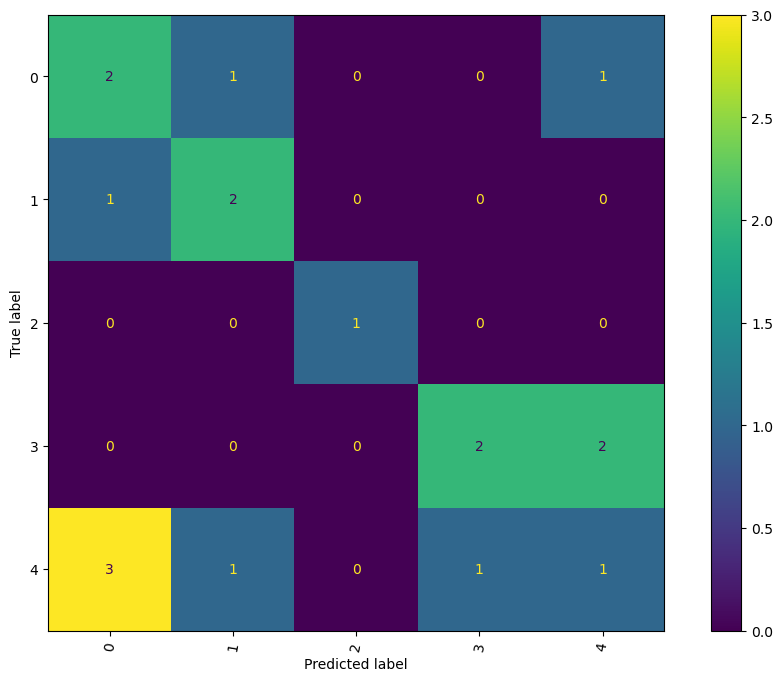

In [177]:
# Making Decision Tree Model
dtc = DecisionTreeClassifier(random_state=40, max_depth = 8, min_samples_leaf = 2)
dtc.fit(X_train,y_train)
metric3=[]
display_classification_report(dtc,metric3)

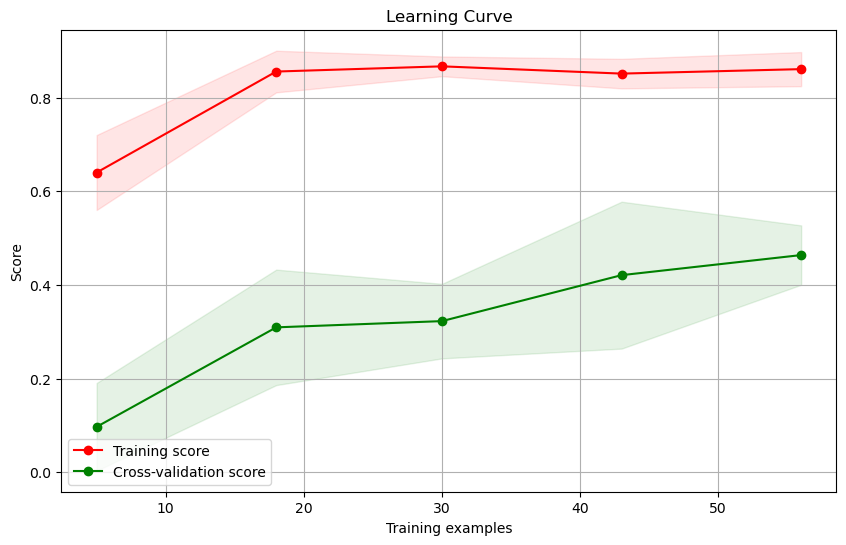

In [178]:
curve(dtc, X_tfidf, y, cv=5, scoring='accuracy')

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.89
Train Accuracy : 1.0
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        17

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.33      0.50         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4
           4       0.83      0.83      0.83         6

    accuracy              

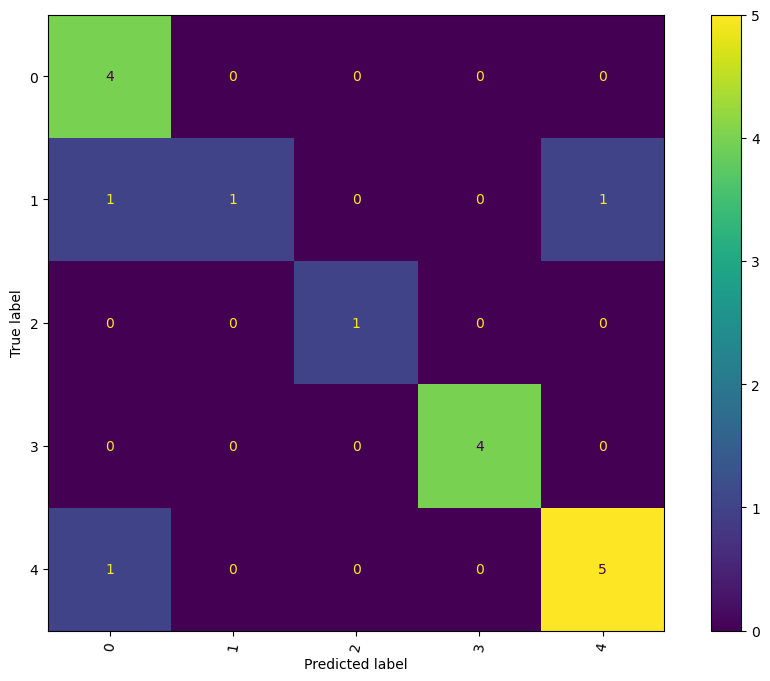

In [179]:
# Making Random Forest Model
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 1000,random_state=40, n_jobs = -1,oob_score=True)
rf.fit(X_train,y_train)
metric4=[]
display_classification_report(rf,metric4)

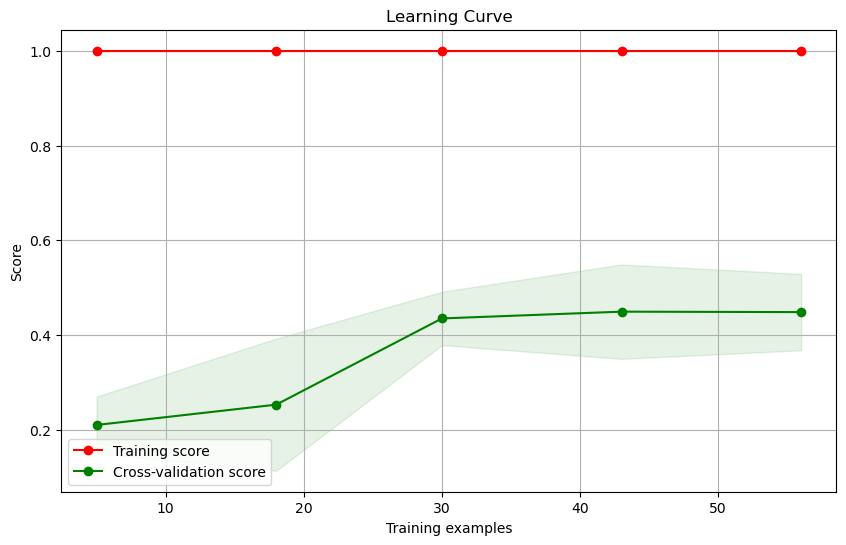

In [180]:
curve(rf, X_tfidf, y, cv=5, scoring='accuracy')

COMPARING ALL THE RESULTS

In [181]:
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ], 
        'Multinomial Naive Bayes': metric1
        }

mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes'] )
log_metric = pd.Series(metric2, name = 'Logistic Regression')
dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier')
rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier')

final_metric = pd.concat([mnb_metric,log_metric,dtc_metric,rfc_metric], axis = 1)

final_metric

,Metric,Multinomial Naive Bayes,Logistic Regression,Decision Tree Classifier,Random Forest Classifier
0,ROC_AUC Score(Tr...,1.00,1.00,0.94,1.00
1,ROC_AUC Score(Test),0.86,0.85,0.65,0.89
2,Accuracy(Train),1.00,1.00,0.81,1.00
3,Accuracy(Test),0.72,0.56,0.44,0.83
4,Precision(Train),1.00,1.00,0.85,1.00
5,Precision(Test),0.72,0.53,0.44,0.87
6,Recall(Train),1.00,1.00,0.81,1.00
7,Recall(Test),0.72,0.56,0.44,0.83
8,F1-Score(Train),1.00,1.00,0.81,1.00
9,F1-Score(Test),0.71,0.53,0.43,0.82


# WITHOUT USING NMF

FOR GETTING THE RESULTS ABOVE WE USED NMF TECHNIQUE. FOR COMPARING THE RESULTS WE GOT USIING NMF WE NEED TO MAKE A MODEL WITHOUT USING NMF. SO NOW I WILL WORK ON THIS NOW

In [182]:
# Making new pandas object on the same dataset
df_new = pd.read_csv("dataset2.csv")  
df_new = df_new.rename(columns={'Query': 'query', 'Department': 'department'})
df_new.head()

,Number,query,department
0,1,I have not yet r...,ISSS
1,2,When will the tr...,Students centre
2,3,Can I participat...,Students centre
3,4,When will be the...,ACES
4,5,I am unable to l...,IT


In [183]:
# Cleaning dataset
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*\]', '', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\S*\d\S*\s*', '', text).strip()
    return text.strip()

In [184]:
df_new['query'] = df_new['query'].apply(clean_text)

In [185]:
df_new = df_new[df_new['query'].notnull()]

In [186]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
X_tfidf = tfidf.fit_transform(df_new['query'])

In [187]:
# Splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_new['department'], test_size=0.25, random_state=0)

In [188]:
# Function to train and evaluate the model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()


Accuracy: 0.3333333333333333
Precision: 0.6018518518518519
Recall: 0.3333333333333333
F1 Score: 0.3992063492063493

Classification Report:
                           precision    recall  f1-score   support

                    ACES       0.00      0.00      0.00         2
Department Administrator       0.11      0.33      0.17         3
                    ISSS       0.50      0.20      0.29         5
                      IT       1.00      0.67      0.80         3
         Students centre       1.00      0.40      0.57         5

                accuracy                           0.33        18
               macro avg       0.52      0.32      0.36        18
            weighted avg       0.60      0.33      0.40        18



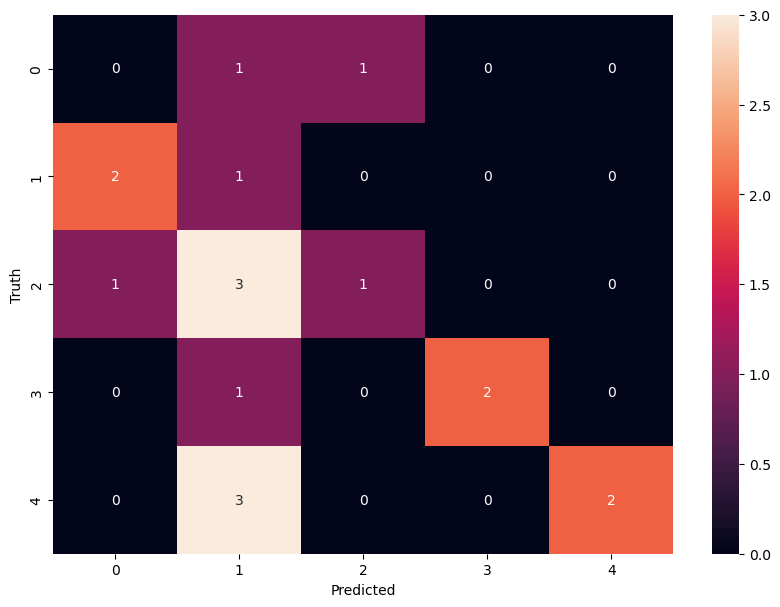

In [189]:
mnb_new = MultinomialNB()
train_evaluate_model(mnb_new, X_train, y_train, X_test, y_test)

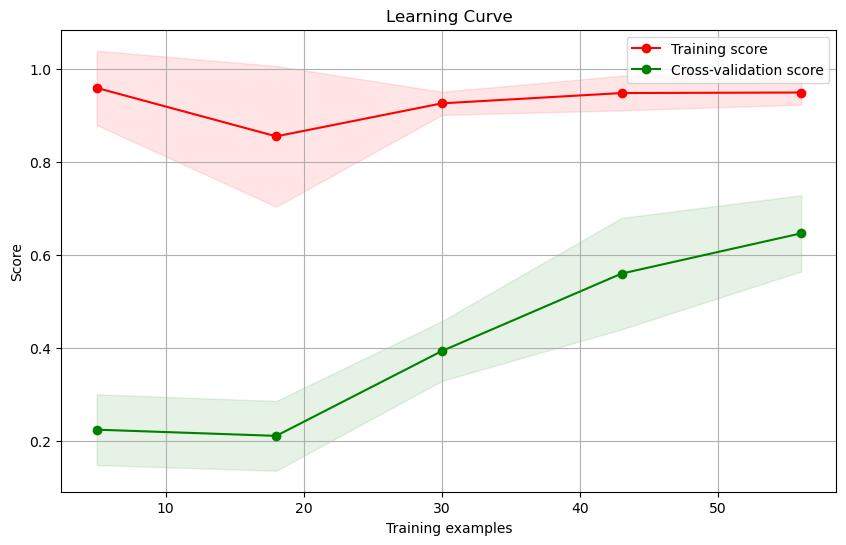

In [190]:
curve(mnb_new, X_tfidf, y, cv=5, scoring='accuracy')

Accuracy: 0.3333333333333333
Precision: 0.7373737373737375
Recall: 0.3333333333333333
F1 Score: 0.40846560846560853

Classification Report:
                           precision    recall  f1-score   support

                    ACES       0.00      0.00      0.00         2
Department Administrator       0.09      0.33      0.14         3
                    ISSS       1.00      0.20      0.33         5
                      IT       1.00      0.67      0.80         3
         Students centre       1.00      0.40      0.57         5

                accuracy                           0.33        18
               macro avg       0.62      0.32      0.37        18
            weighted avg       0.74      0.33      0.41        18



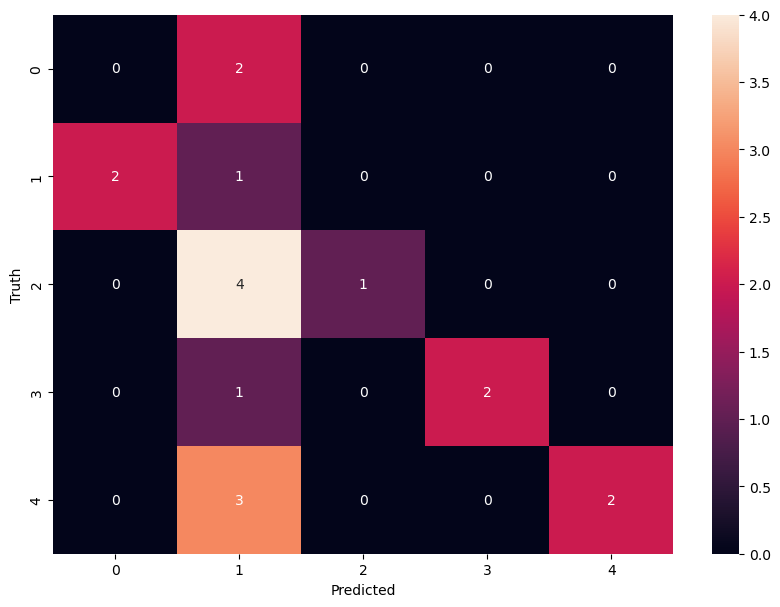

In [191]:
log_reg_new = LogisticRegression(random_state=40,solver='liblinear')
train_evaluate_model(log_reg_new, X_train, y_train, X_test, y_test)

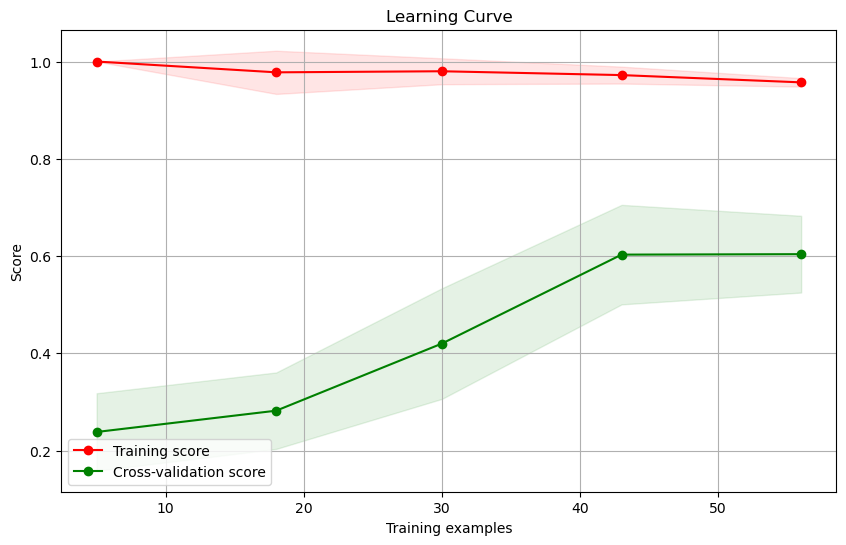

In [192]:
curve(log_reg_new, X_tfidf, y, cv=5, scoring='accuracy')

Accuracy: 0.5555555555555556
Precision: 0.7083333333333334
Recall: 0.5555555555555556
F1 Score: 0.5420875420875421

Classification Report:
                           precision    recall  f1-score   support

                    ACES       0.00      0.00      0.00         2
Department Administrator       0.25      0.67      0.36         3
                    ISSS       1.00      0.20      0.33         5
                      IT       1.00      1.00      1.00         3
         Students centre       0.80      0.80      0.80         5

                accuracy                           0.56        18
               macro avg       0.61      0.53      0.50        18
            weighted avg       0.71      0.56      0.54        18



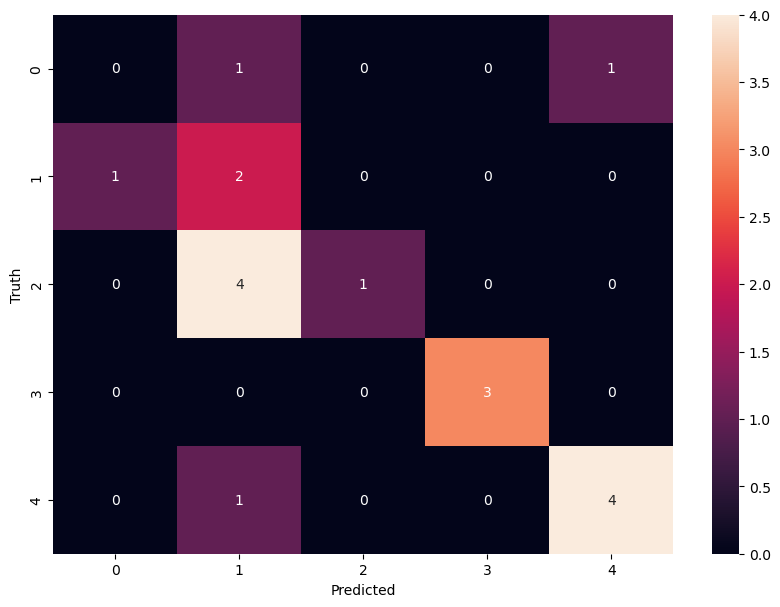

In [193]:
dtc_new = DecisionTreeClassifier(random_state=40)
train_evaluate_model(dtc_new, X_train, y_train, X_test, y_test)

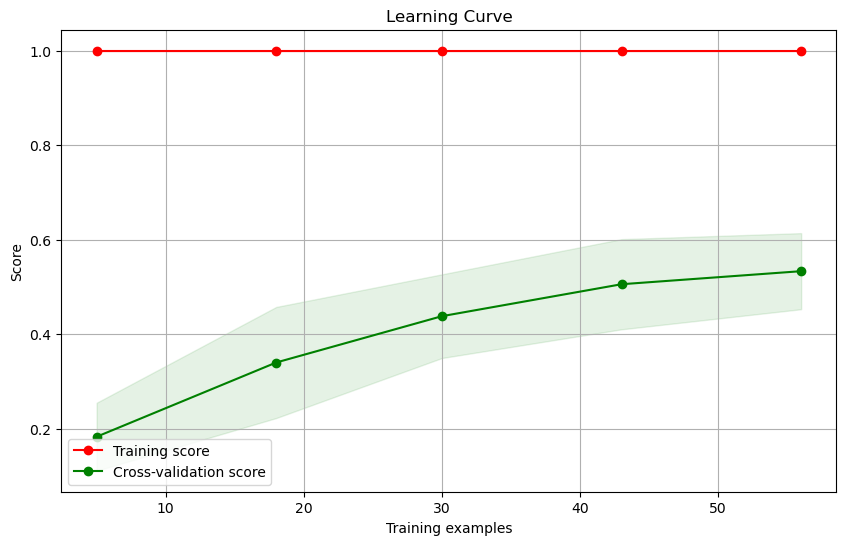

In [194]:
curve(dtc_new, X_tfidf, y, cv=5, scoring='accuracy')

Accuracy: 0.5
Precision: 0.7638888888888888
Recall: 0.5
F1 Score: 0.4895061728395062

Classification Report:
                           precision    recall  f1-score   support

                    ACES       0.00      0.00      0.00         2
Department Administrator       0.25      1.00      0.40         3
                    ISSS       1.00      0.20      0.33         5
                      IT       1.00      0.33      0.50         3
         Students centre       1.00      0.80      0.89         5

                accuracy                           0.50        18
               macro avg       0.65      0.47      0.42        18
            weighted avg       0.76      0.50      0.49        18



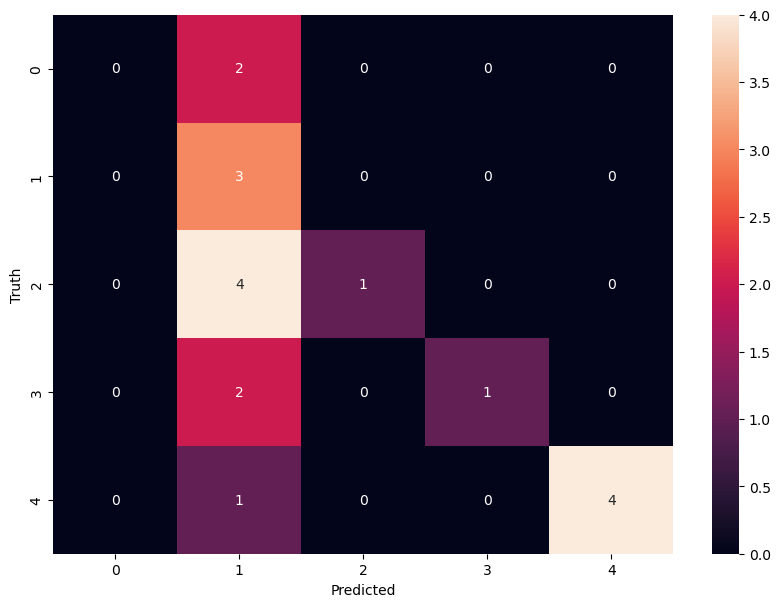

In [195]:
rf_new = RandomForestClassifier(n_estimators = 100,random_state=40)
train_evaluate_model(rf_new, X_train, y_train, X_test, y_test)

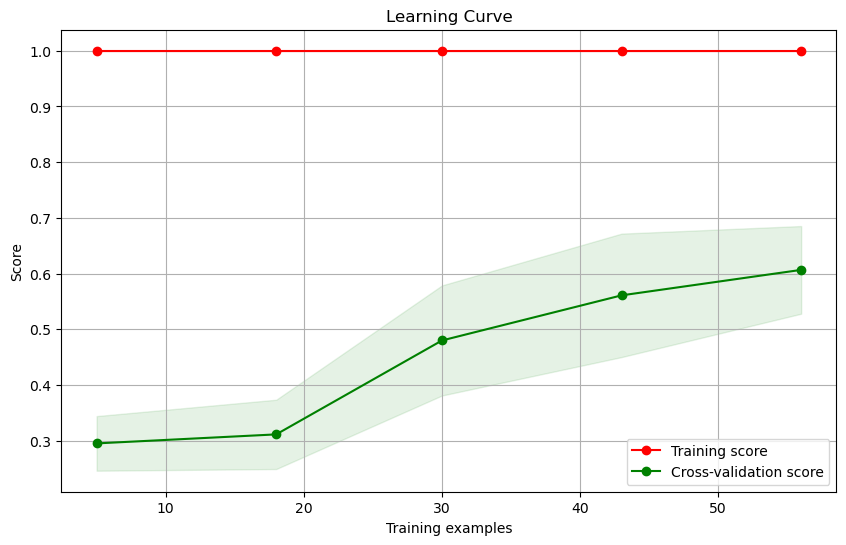

In [196]:
curve(rf_new, X_tfidf, y, cv=5, scoring='accuracy')